# Let's learn and predict baseline drug prices that pharmacies pay!

![](images/drug_prices.jpeg)

### Pharmacy Invoice Price Prediction model 
#### Pricing calculations are extremely complex in Pharma world. During the customer(Pharmacy) onboarding process a Wholesaler can make use of a baseline price predicting model.

- This baseline price prediction model that will help Wholesaler's sales representatives while onboarding the customers.
- This Model is developed based on NADAC data, which contain approximate invoice prices payed by Pharmacies.
- Additional datasets, minor version of Master Drug Data Base MDDB is considered for compatitive purposes 



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder,StandardScaler
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier

from autofeat import AutoFeatRegressor

from sklearn import set_config
set_config(display="diagram")

from warnings import filterwarnings
filterwarnings('ignore')
import missingno as msno

# Advanced Regression ensamble models
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Pharmacy Supply Chain
- Below Diagram shows the general flow of pharmacy supply chain starting from a manufacturer to the pateint.
![](images/drug_supply_chain.png)

- Reference: https://www.fda.gov/drugs/drug-shortages/graphic-drug-supply-chain-example

### Pricing Terminology:
    - Manufacturer to Wholesaler
        - Wholesale Acquisition Cost (WAC)
        - Retail Price
    - Wholesaler to Retailer/ Pharmacy
        - Average Wholesale Price (AWP)
        - Invoice Price


### Exploratory Data Analysis

#### NADAC Dataset
- Medicaid.gov contains National Average Drug Acquisition Cost (NADAC) which is the approximate invoice price pharmacies pay for medications in the United States. This applies to chain and independent pharmacies but not mail order and Speciality pharmacy. Rebates pharmacies may receive after paying an invoice are not included. The NADAC data is calculated by the Centers For Medicare and Medicaid Services.
<br><br>
- The National Average Drug Acquisition Cost (NADAC) is based on the retail price survey and focuses on the retail community pharmacy acquisition costs. CMS has mandated that Medicaid pharmacy programs reimburse the Actual Acquisition Cost (AAC) of drugs plus a professional dispensing fee. The NADAC represents the average acquisition cost.
<br><br>
- References: 
    -         https://data.medicaid.gov/dataset/dfa2ab14-06c2-457a-9e36-5cb6d80f8d93
    -         https://dhhr.wv.gov/bms/BMS%20Pharmacy/Documents/NADAC%20Survey.pdf

In [2]:
nadac_df = pd.read_csv('data/nadac-national-average-drug-acquisition-cost-08-03-2022.csv')
nadac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776578 entries, 0 to 776577
Data columns (total 12 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   NDC Description                            776578 non-null  object 
 1   NDC                                        776578 non-null  int64  
 2   NADAC_Per_Unit                             776578 non-null  float64
 3   Effective_Date                             776578 non-null  object 
 4   Pricing_Unit                               776578 non-null  object 
 5   Pharmacy_Type_Indicator                    776578 non-null  object 
 6   OTC                                        776578 non-null  object 
 7   Explanation_Code                           776578 non-null  object 
 8   Classification_for_Rate_Setting            776578 non-null  object 
 9   Corresponding_Generic_Drug_NADAC_Per_Unit  19515 non-null   float64
 10  Correspo

### NADAC Data Dictionary
- **NDC Description**: National Drug Code Description 
    -             (Identifieds the drug name, strength and dosage form of the drug product)
- **NDC**            : National Drug Code
    -             (11-digit code maintained by the FDA that includes labeler code(first 4-5 digits), product code  & package code (last 5 to 6 digits)
- **NADAC Per Unit** : The National Average Drug Aquisition Cost per Unit
- **Effective Date** : The effective date of the NADAC Per Unit Cost
- **Pricing Unit**   : Indicates the pricing unit for the associated NDC ('ML', 'GM', or 'EA')
- **Pharmacy Type Indicator**: Where this data is collected C (Chain) or I (Independent) pharmacies
- **OTC**: Indicates whether this drug is OVer The Counter product or not (Y or N)  
- **Explanation Code**: Codes that pertain to how the NADAC was calculated, ( Codes 1 to 5) 
- **Classification for Rate Settings**: Indicates whether product is Brand(B), Generic (G), ANDA, B-ANDA, B-BIO
    - ANDA (approved under and Abbreviated New Drug Application) 
    - B-BIO (Brand Bio Similar)
- **Corresponding Generic Drug NADAC Per Unit**: The NADAC for corresponding generic product (if NDC is a Brand)
- **Corresponding Generic Drug Effective Date**: The effective date when NADAC is assigned to generic drug 

In [3]:
nadac_df.sample(10)

,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
142822,PAROXETINE HCL 30 MG TABLET,68382009916,0.10980,01/19/2022,EA,C/I,N,1,G,NaN,NaN,02/02/2022
755001,CALCIUM ACETATE 667 MG CAPSULE,62135019122,0.29534,07/20/2022,EA,C/I,N,1,G,NaN,NaN,08/03/2022
334947,HISTEX PD 0.938 MG/ML DROP,28595080130,0.49773,03/23/2022,ML,C/I,Y,"1, 5",G,NaN,NaN,04/06/2022
488923,METFORMIN HCL 500 MG TABLET,71093013206,0.01570,05/18/2022,EA,C/I,N,1,G,NaN,NaN,05/18/2022
332897,FEBUXOSTAT 80 MG TABLET,72205002930,0.93355,03/23/2022,EA,C/I,N,1,G,NaN,NaN,04/06/2022
104457,CIPROFLOXACIN HCL 250 MG TAB,58657067501,0.09900,01/19/2022,EA,C/I,N,1,G,NaN,NaN,01/26/2022
225375,AMOX-CLAV 400-57 MG/5 ML SUSP,16714029303,0.07133,02/23/2022,ML,C/I,N,"1, 5",G,NaN,NaN,03/09/2022
172724,TRAMADOL-ACETAMINOPHEN 37.5-325 MG TAB,68382033405,0.11471,01/19/2022,EA,C/I,N,1,G,NaN,NaN,02/16/2022
315802,NIFEDIPINE ER 90 MG TABLET,59651029701,0.37810,03/23/2022,EA,C/I,N,1,G,NaN,NaN,03/30/2022
104265,CHLORTHALIDONE 25 MG TABLET,60687031725,0.17050,01/19/2022,EA,C/I,N,1,G,NaN,NaN,01/26/2022


In [4]:
mddb_df = pd.read_csv('data/mmdb.csv') 
mddb_df['AWP'] = mddb_df['AWP'] / mddb_df['TOTPCKQTY']
mddb_df['AWPTOTAL'] = mddb_df['AWP'] * mddb_df['TOTPCKQTY']
mddb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285388 entries, 0 to 285387
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   NDC           285388 non-null  int64  
 1   GENERIC_NAME  285388 non-null  object 
 2   GPID          285388 non-null  object 
 3   GPPC          285388 non-null  object 
 4   STRENGTHDS    285388 non-null  float64
 5   STRENGTHUM    167594 non-null  object 
 6   SIZE          285388 non-null  float64
 7   FORM          285388 non-null  object 
 8   SIZEUOM       285388 non-null  object 
 9   PACKQTY       285388 non-null  int64  
 10  TOTPCKQTY     285388 non-null  float64
 11  WAC           285388 non-null  float64
 12  WACTOTAL      285388 non-null  float64
 13  AWP           285388 non-null  float64
 14  AWPTOTAL      285388 non-null  float64
dtypes: float64(7), int64(2), object(6)
memory usage: 32.7+ MB


### MDDB Data Dictionary
- This dataset contains additional information which gives us drug classification, Wholesale Aquisition Cost (WAC) and Average Wholesale Price (AWP) 

#### This is a shorter version of  Master Drug Data Base (MDDB)
- **NDC**            : National Drug Code
    -             (11-digit code maintained by the FDA that includes labeler code(first 4-5 digits), product code  & package code (last 5 to 6 digits)
- **GENERIC_NAME** : Identifieds the drug name, strength and dosage form of the drug product
- **GPID** : Generic Product Identifier 
    -      14 Character GPID consists of heirarchy of Drug Group (first 2 chars), Drug Class (first 4 chars), Drug Subclass (first 6 chars), Drug Name(first 8 chars), Drug Name Ext (first 10 chars), Dosage Form (first 12 chars) & Strength (total 14 chars) 
- **GPPC** : Generic Product Packaging Code
    - 8 character code, The first five characters are random and last three represent Package Description, Package Size, Package Size unit of Measure, Package Quantity and Unit Dose / Unit of Use Packaging Code  
- **STRENGTHDS**: Digits representing strength of the Chemical Formula
- **STRENGTHUM**: Unit Measures of the Chemical Formula (ML, MG, etc)
- **SIZE**: Number that represnts the size interms of capsules or ML of liquid
- **FORM**: Form in which drug is composed (Tablets, Capsules, Liquid etc) 
- **SIZEUOM**: Unit of Measure of Size mentioned above
- **PACKQTY**: Number of items in the same package
- **TOTPCKQTY**: SIZE x PACKQTY
- **WAC**: Wholesaler Acquisition Cost (Price payed by Wholesaler/Distributor to Manufacturer)
- **WACTOTAL**: WAC x TOTPCKQTY
- **AWP**: Average Wholesale Price (Average Price Payed by Retailer to Wholesaler) 
- **AWPTOTAL**: AWP x TOTPCKQTY


In [37]:
mddb_df.query("GPPC == '26341966' ")

,NDC,GENERIC_NAME,GPID,GPPC,STRENGTHDS,STRENGTHUM,SIZE,FORM,SIZEUOM,PACKQTY,TOTPCKQTY,WAC,WACTOTAL,AWP,AWPTOTAL
14589,378670977,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,1.83,164.84,11.447556,1030.28
46013,13668010790,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,1.00,90.00,10.187000,916.83
79502,42291072190,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,4.16,374.51,11.447667,1030.29
160195,62175030246,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.46,41.42,11.447667,1030.29
160645,62856024390,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,10.61,955.03,12.733778,1146.04
186567,68180022009,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,2.29,206.25,11.460222,1031.42
200487,42291072290,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.69,62.16,11.447667,1030.29
207415,65162072409,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.88,79.43,11.447667,1030.29
235870,51991068390,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.33,30.00,11.460333,1031.43
256485,67877044390,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.27,24.30,11.458333,1031.25


#### Split NADAC dataset into three subsets: Generics, Brands and OTC

In [6]:
nadac_df['Classification_for_Rate_Setting'].value_counts()

G         721807
B          53096
B-ANDA      1631
B-BIO         44
Name: Classification_for_Rate_Setting, dtype: int64

In [7]:
nadac_brands_df   = nadac_df.query("(Classification_for_Rate_Setting == 'B') & (OTC == 'N')")
nadac_generics_df = nadac_df.query("(Classification_for_Rate_Setting == 'G') & (OTC == 'N')")
nadac_otc_df      = nadac_df.query("OTC == 'Y'")

In [8]:
nadac_generics_df.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
12,ABACAVIR 300 MG TABLET,378410591,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
13,ABACAVIR 300 MG TABLET,904687404,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
14,ABACAVIR 300 MG TABLET,904687406,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
15,ABACAVIR 300 MG TABLET,31722055760,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
16,ABACAVIR 300 MG TABLET,50268004911,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022


In [9]:
pd.value_counts(nadac_generics_df.dtypes)

object     9
float64    2
int64      1
dtype: int64

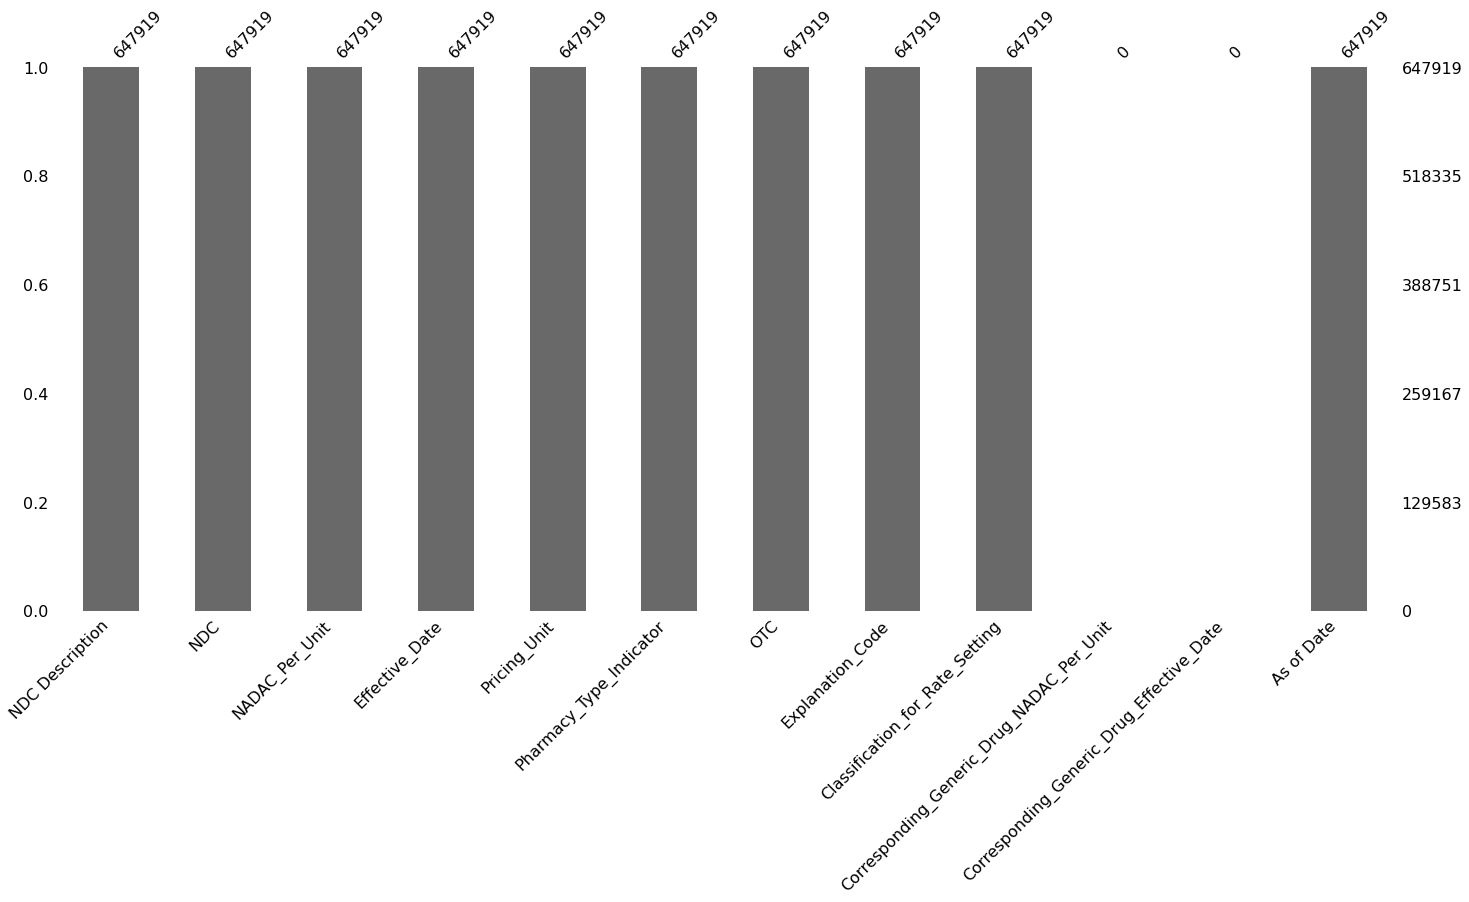

In [10]:
msno.bar(nadac_generics_df);

#### Tried to auto find features using AutoFeatRegressor from autofeat library
- This fails, needs to explore alternatives

In [11]:
# Auto Feature detection using AutoFeatRegressor
# null_columns = nadac_generics_df.columns[nadac_generics_df.isnull().any()]
# explore_df = nadac_generics_df.copy().drop(columns = null_columns)
# X = explore_df.drop('NADAC_Per_Unit', axis = 1)
# y = explore_df['NADAC_Per_Unit']

# cat_cols = explore_df.select_dtypes(exclude=np.number).columns.to_list()
# autoFeatmodel = AutoFeatRegressor(categorical_cols = cat_cols)
# df = autoFeatmodel.fit_transform(X, y)
# pred = model.predict(X_test)
# print("Final R^2: %.4f" % model.score(df, y))


### Data Preparation
- Drop NAN columns and unrelated columns to dependent variable NADAC_Per_Unit
- Transform using Label Encoder (ONE HOT ENCODER creates many columns)

In [12]:
# Dropping unrelated columns
cols_to_drop = ['NDC','OTC','Corresponding_Generic_Drug_NADAC_Per_Unit',
                'Corresponding_Generic_Drug_Effective_Date', 'As of Date',
               'Pharmacy_Type_Indicator','Classification_for_Rate_Setting']
nadac_generics_df = nadac_generics_df.drop(columns = cols_to_drop)
nadac_generics_df.isna().sum()

NDC Description     0
NADAC_Per_Unit      0
Effective_Date      0
Pricing_Unit        0
Explanation_Code    0
dtype: int64

In [13]:
# Label encoder & decoder functions 
encoders = []
def label_encode(cat_columns, df_enc):
    for c in cat_columns:
          le = LabelEncoder()
          encoders.append( le.fit(list(df_enc[c].astype(str).values)))
          df_enc[c] = le.transform(list(df_enc[c].astype(str).values))
            
def label_decode(df_enc):
    output = df_enc.copy()
    for col in cat_columns:
        output[col] = encoders[cat_columns.index(col)].inverse_transform(df_enc[col])
    return output

In [14]:
cat_columns = nadac_generics_df.select_dtypes(exclude=np.number).columns.to_list()
print(f'Categorical columns: {cat_columns}\n\n')
nadac_generics_df_enc = nadac_generics_df.copy()
label_encode(cat_columns,nadac_generics_df_enc)
nadac_generics_df_enc.sample(10)

Categorical columns: ['NDC Description', 'Effective_Date', 'Pricing_Unit', 'Explanation_Code']




,NDC Description,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Explanation_Code
358967,1036,0.04814,16,0,0
759516,827,13.74746,45,2,1
10812,1090,0.26532,2,0,0
694192,1865,0.13000,37,0,0
335287,1118,0.05169,16,0,0
349777,81,0.28570,16,0,0
377859,364,0.29283,22,0,0
187545,1365,0.24012,9,0,0
401975,268,0.58858,22,2,1
93234,1886,0.16071,2,0,0


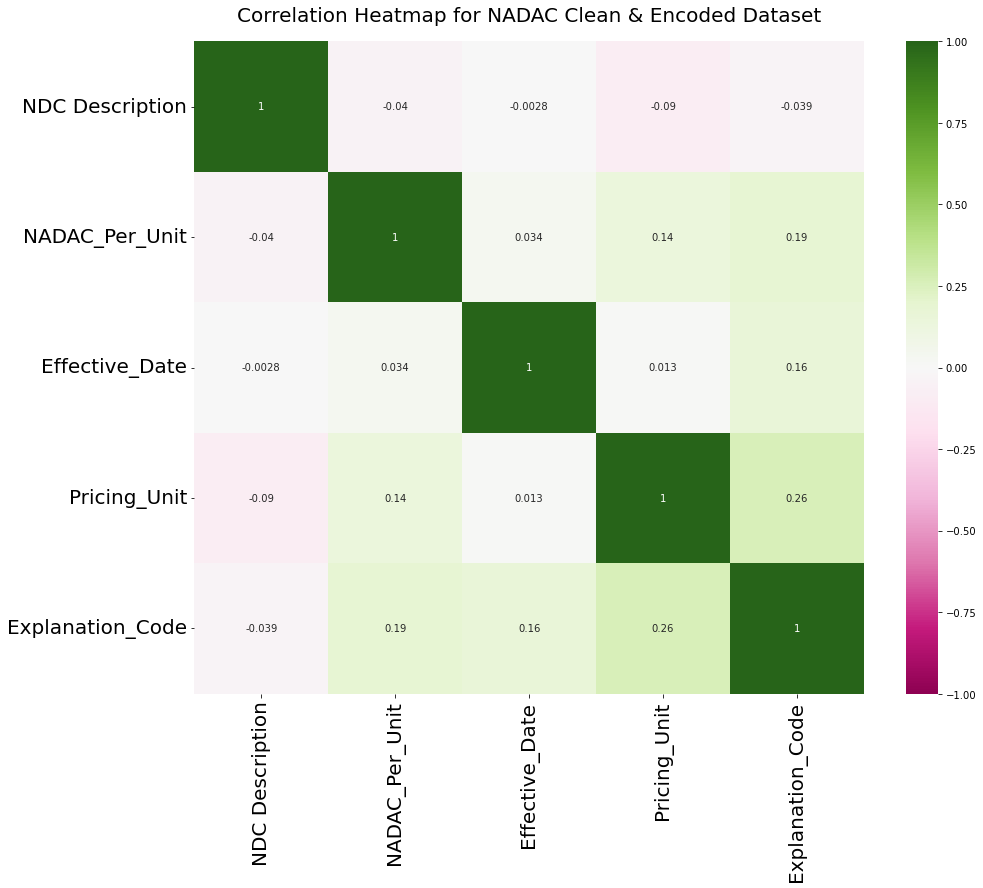

In [15]:
# Correlation Analysis
f, ax = plt.subplots(figsize=(15, 12))
ax.set_title('Correlation Heatmap for NADAC Clean & Encoded Dataset', pad=20,fontsize = 20)
g = sns.heatmap(nadac_generics_df_enc.corr(), vmin=-1, vmax=1, annot=True, cmap='PiYG')
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 20)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 20);

**Observation**: Even though NDC Description has negative coorelation with other features, it is important, so I am keeping it. 

<AxesSubplot:xlabel='NADAC_Per_Unit', ylabel='Density'>

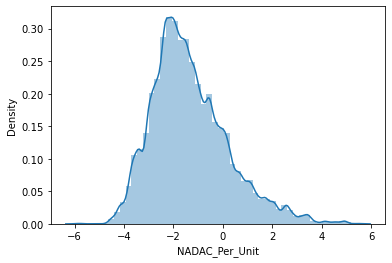

In [16]:
sns.distplot(np.log(nadac_generics_df_enc['NADAC_Per_Unit']))

<AxesSubplot:xlabel='NDC Description', ylabel='Density'>

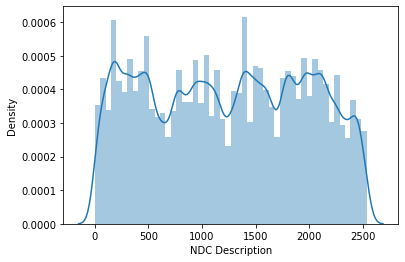

In [17]:
sns.distplot(nadac_generics_df_enc['NDC Description'])

<Figure size 2160x576 with 0 Axes>

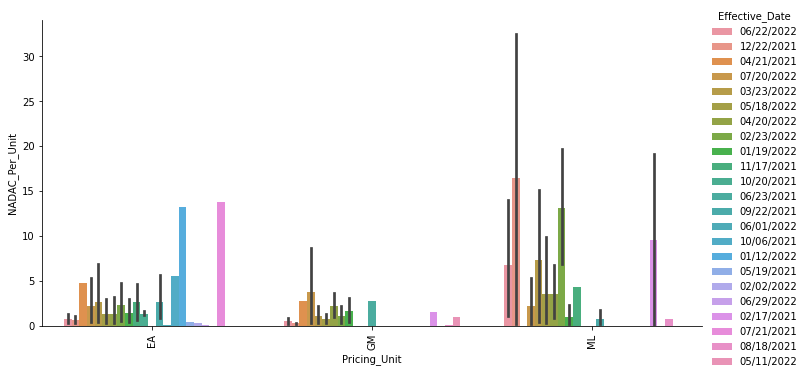

In [18]:
plt.figure(figsize=(30,8))
g = sns.catplot(x='Pricing_Unit', y ='NADAC_Per_Unit', hue='Effective_Date', data=nadac_generics_df.sample(1000), 
            kind="bar", aspect=2, height=5)
g.set_xticklabels(rotation=90);

### Modeling
 - Linear Regression and Support Vector Regression models produced low accuracy scores 
 - Found RandomForestRegressor to be the best fit 

In [19]:
X = nadac_generics_df_enc.drop(columns = ['NADAC_Per_Unit'], axis = 1)
y = nadac_generics_df_enc['NADAC_Per_Unit']

#Sequencial Feature Selection
lr = LinearRegression()
sfs = SequentialFeatureSelector(lr,n_features_to_select=3)
sfs.fit(X.copy(), y)
print('SFS selected Columns: ', X.columns[sfs.get_support()].values)

# X = X.drop(columns = ['Effective_Date'], axis = 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=42)

SFS selected Columns:  ['NDC Description' 'Pricing_Unit' 'Explanation_Code']


In [20]:
lr_model     = LinearRegression().fit(X_train,y_train)
lr_y_pred    = lr_model.predict(X_test)
lr_train_acc = round(lr_model.score(X_train, y_train)*100, 2)
lr_test_acc  = round(lr_model.score(X_test, y_test)*100, 2)
print(lr_train_acc, lr_test_acc)

4.49 4.17


In [90]:
lasso_model     = Lasso().fit(X_train,y_train)
lasso_y_pre     = lasso_model.predict(X_test)
lasso_train_acc = round(lasso_model.score(X_train, y_train)*100, 2)
lasso_test_acc  = round(lasso_model.score(X_test, y_test)*100, 2)
print('Default Lasso Model Scores:' ,lasso_train_acc, lasso_test_acc)
lasso_params = {'alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
lasso_grid = GridSearchCV(lasso_model, param_grid = lasso_params).fit(X_train,y_train)
lasso_grid.best_estimator_
lasso_train_acc = round(lasso_grid.score(X_train, y_train)*100, 2)
lasso_test_acc  = round(lasso_grid.score(X_test, y_test)*100, 2)
print('Grid search Lasso Model Scores:' ,lasso_train_acc, lasso_test_acc)

Default Lasso Model Scores: 2.04 1.95
Grid search Lasso Model Scores: 4.49 4.18


In [92]:
ridge_model     = Ridge().fit(X_train,y_train)
ridge_y_pre     = ridge_model.predict(X_test)
ridge_train_acc = round(ridge_model.score(X_train, y_train)*100, 2)
ridge_test_acc  = round(ridge_model.score(X_test, y_test)*100, 2)
print('Default Ridge Model Scores:' ,ridge_train_acc, ridge_test_acc)
ridge_params = {'fit__alpha':[550, 580, 600, 620, 650]}
ridge_grid = GridSearchCV(ridge_model, param_grid = lasso_params).fit(X_train,y_train)
ridge_grid.best_estimator_
ridge_train_acc = round(ridge_grid.score(X_train, y_train)*100, 2)
lasso_test_acc  = round(ridge_grid.score(X_test, y_test)*100, 2)
print('Grid search Ridge Model Scores:' ,ridge_train_acc, ridge_test_acc)

Default Ridge Model Scores: 4.49 4.17
Grid search Ridge Model Scores: 4.49 4.17


In [22]:
rf_model  = RandomForestRegressor().fit(X_train,y_train)
y_pred    = rf_model.predict(X_test)
train_acc = round(rf_model.score(X_train, y_train)*100, 2)
test_acc  = round(rf_model.score(X_test, y_test)*100, 2)
print(train_acc, test_acc)

99.85 99.8


### Evaluation

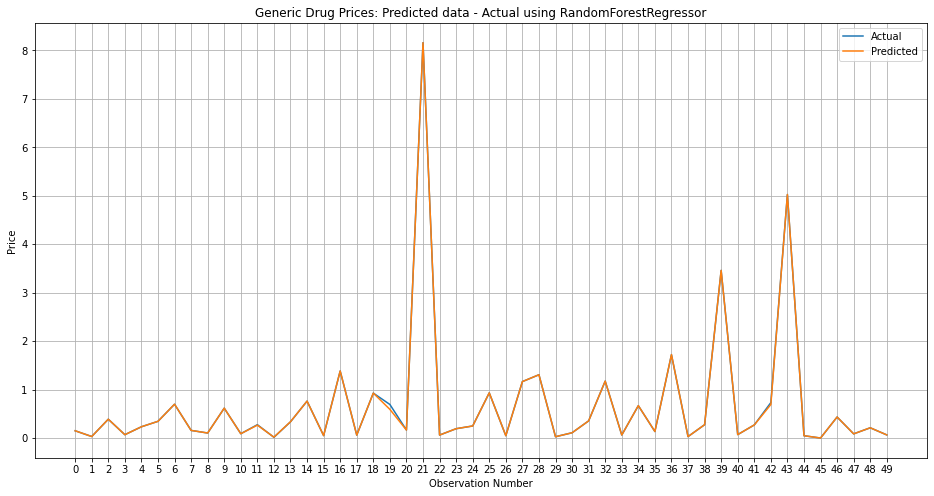

In [24]:
number_of_observations=50
x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(16,8))
plt.plot(x_ax, y_test[:number_of_observations], label="Actual")
plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
plt.title('Generic Drug Prices: Predicted data - Actual using RandomForestRegressor')
plt.xlabel('Observation Number')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show();

#### Evaluating by using sklearn.metrics

In [25]:
mse       = mean_squared_error(y_test,y_pred )
max_error = max_error(y_test,y_pred )
r2_score  = r2_score(y_test,y_pred )
print('Mean Squared Error:',round(mse,2))
print('Max Error:',round(max_error,2))
print('r2_score :',round(r2_score,2))

Mean Squared Error: 0.13
Max Error: 20.17
r2_score : 1.0


#### Predicting

In [107]:
def predict_price(sample_df):
    """ Function takes in a sample dataframe from the clean dataset, 
    and transforms the feature columns 
    and ouputs the the predicted price array:"""

    x     = np.zeros(4)
    x[0]  = encoders[cat_columns.index('NDC Description')].transform([sample_df['NDC Description'].values[0]])
    x[1]  = encoders[cat_columns.index('Effective_Date')].transform([sample_df['Effective_Date'].values[0]])
    x[2]  = encoders[cat_columns.index('Pricing_Unit')].transform([sample_df['Pricing_Unit'].values[0]])
    x[3]  = encoders[cat_columns.index('Explanation_Code')].transform([sample_df['Explanation_Code'].values[0]])

    x = scaler.transform([x])
    predicted_price = rf_model.predict(x)

    return predicted_price
    

In [171]:
def get_predictions_dict(sample_df, predicted_price):
    
    results = []
    ndc = nadac_df.iloc[sample_df.index]['NDC'].values[0]
    mddb_prices_df = mddb_df[['WAC','AWP']][mddb_df['NDC'] == ndc]
    wac    = 'No Data'
    awp    = 'No Data'
    wpp    = 'No Data'
    
    if not mddb_prices_df.empty:
        wac   = round(mddb_prices_df['WAC'].values[0], 2)
        awp   = round(mddb_prices_df['AWP'].values[0], 2)
        wpp   = str(round(np.abs((awp-wac) * 100/wac), 2)) + '%'
    
    results.append({'NDC':ndc,
                       'Actual_Invoice_Price': round(sample_df['NADAC_Per_Unit'].values[0],2),
                       'Predicted_Invoice_Price':round(predicted_price[0], 2),
                       'Wholesaler_Aquisition_Cost' : wac,
                       'Average_Wholesale_Price' : awp,
                       'Wholesaler_Profit_Percent' : wpp
                  })
    
    return results

In [172]:
results_df = pd.DataFrame( columns=['NDC', 'Actual_Invoice_Price',
                                    'Predicted_Invoice_Price','Wholesaler_Aquisition_Cost',
                                    'Average_Wholesale_Price', 'Wholesaler_Profit_Percent'])

for i in range(1,10):
    sample_df = nadac_generics_df.sample(1)
    predicted_price = predict_price(sample_df)   
    results = get_predictions_dict(sample_df,predicted_price)
    df_dictionary = pd.DataFrame.from_dict(results)
    results_df = pd.concat([results_df, df_dictionary])

results_df

,NDC,Actual_Invoice_Price,Predicted_Invoice_Price,Wholesaler_Aquisition_Cost,Average_Wholesale_Price,Wholesaler_Profit_Percent
0,713066915,3.64,3.64,5.25,6.56,24.95%
0,68001011203,0.13,0.13,0.3,5.89,1863.33%
0,50228042830,0.26,0.26,0.33,13.88,4106.06%
0,378967160,0.06,0.07,0.17,0.73,329.41%
0,51862033405,0.13,0.13,0.4,0.92,130.0%
0,24658076016,0.12,0.11,0.15,0.39,160.0%
0,781591401,1.40,1.40,4.91,6.14,25.05%
0,70954027520,3.25,3.25,No Data,No Data,No Data
0,72578009306,1.38,1.65,2.18,2.73,25.23%


In [173]:
def predict_by_gppc(gppc):
    results_df = pd.DataFrame( columns=['NDC', 'Actual_Invoice_Price',
                                    'Predicted_Invoice_Price','Wholesaler_Aquisition_Cost',
                                    'Average_Wholesale_Price', 'Wholesaler_Profit_Percent'])
    gppc_df       = mddb_df.query("GPPC ==@gppc")
    gppc_ndcs     = gppc_df['NDC'].values
    to_predict_df = nadac_df[nadac_df['NDC'].isin(gppc_ndcs)]
    for index in to_predict_df.index:
        try:
            sample_df       = nadac_df.iloc[[index]]
            predicted_price = predict_price(sample_df)
            results         = get_predictions_dict(sample_df,predicted_price)
            df_dictionary   = pd.DataFrame.from_dict(results)
            results_df      = pd.concat([results_df, df_dictionary])
        except:
            pass
    
    return results_df


In [174]:
gppc_results_df = predict_by_gppc('26341966')
gppc_results_df

,NDC,Actual_Invoice_Price,Predicted_Invoice_Price,Wholesaler_Aquisition_Cost,Average_Wholesale_Price,Wholesaler_Profit_Percent
0,13668010790,0.24,0.24,1.00,10.19,919.0%
0,62175030246,0.24,0.24,0.46,11.45,2389.13%
0,65862072190,0.24,0.24,0.33,11.46,3372.73%
0,67877044390,0.24,0.24,0.27,11.46,4144.44%
0,68180022009,0.24,0.24,2.29,11.46,400.44%
...,...,...,...,...,...,...
0,13668010790,0.24,0.24,1.00,10.19,919.0%
0,62175030246,0.24,0.24,0.46,11.45,2389.13%
0,65862072190,0.24,0.24,0.33,11.46,3372.73%
0,67877044390,0.24,0.24,0.27,11.46,4144.44%


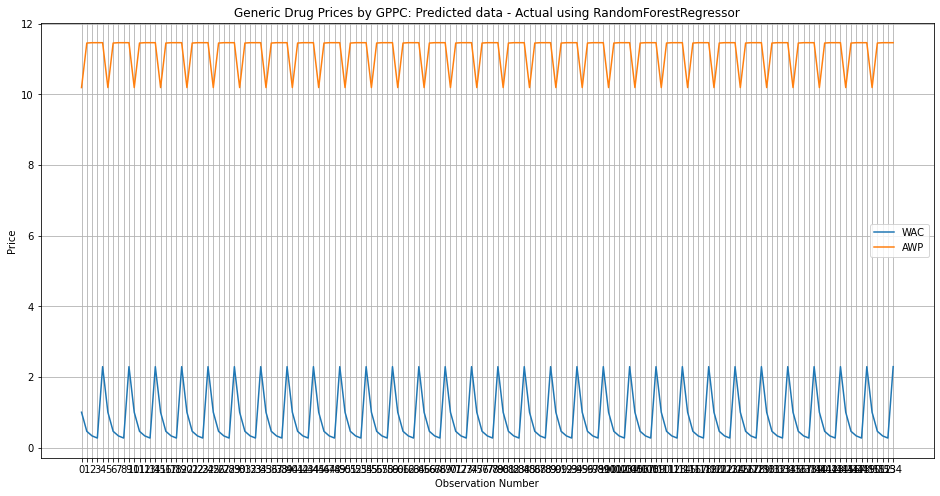

In [175]:
number_of_observations=gppc_results_df.shape[0]
x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(16,8))
# plt.plot(x_ax, gppc_results_df['Actual_Invoice_Price'], label="Actual", color='blue')
# plt.plot(x_ax, gppc_results_df['Predicted_Invoice_Price'], label="Predicted", color='red')
plt.plot(x_ax, gppc_results_df['Wholesaler_Aquisition_Cost'], label="WAC")
plt.plot(x_ax, gppc_results_df['Average_Wholesale_Price'], label="AWP")
plt.title('Generic Drug Prices by GPPC: Predicted data - Actual using RandomForestRegressor')
plt.xlabel('Observation Number')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show();

In [161]:
def predict_by_gpid(gpid):
    results_df = pd.DataFrame( columns=['NDC', 'Actual_Price',
                                    'Predicted_Price','Wholesaler_Aquisition_Cost',
                                    'Average_Wholesale_Price', 'Wholesaler_Profit_Percent'])
    gpid_df       = mddb_df.query("GPID == @gpid")
    gpid_ndcs     = gpid_df['NDC'].values
    to_predict_df = nadac_df[nadac_df['NDC'].isin(gpid_ndcs)]
    for index in to_predict_df.index:
        try:
            sample_df       = nadac_df.iloc[[index]]
            predicted_price = predict_price(sample_df)
            results         = get_predictions_dict(sample_df,predicted_price)
            df_dictionary   = pd.DataFrame.from_dict(results)
            results_df      = pd.concat([results_df, df_dictionary])
        except:
            pass
        
    return results_df

In [163]:
gpid_results_df = predict_by_gpid('49270076100620')
gpid_results_df

,NDC,Actual_Price,Predicted_Price,Wholesaler_Aquisition_Cost,Average_Wholesale_Price,Wholesaler_Profit_Percent
0,13668010705,0.24,0.24,1.00,10.19,919.0%
0,13668010730,0.24,0.24,1.00,10.19,919.0%
0,13668010790,0.24,0.24,1.00,10.19,919.0%
0,62175030232,0.24,0.24,0.47,11.45,2336.17%
0,62175030243,0.24,0.24,0.44,11.45,2502.27%
...,...,...,...,...,...,...
0,65862072190,0.24,0.24,0.33,11.46,3372.73%
0,67877044330,0.24,0.24,0.30,11.44,3713.33%
0,67877044390,0.24,0.24,0.27,11.46,4144.44%
0,68180022006,0.24,0.24,2.29,11.46,400.44%


### TODO : Other Ideas
- Seek alternatives for auto feature selection
- Create a python class and bring in all capstone methods into it
- Work on NDC description splitting it using NLP and introduce new columns for regression
- Work with effective date
- Integrate this model with Rasa 
    - To create chat bot that recommends medication when illness is entered
    - Consider Therapuetic categories for classification
